<h1 style="text-align: center;">Sequence Labeling<h1>

Prepare libraries

In [5]:
# here put every import you need e.g. import nltk
# it's better to load what you need from the package by from [] import [] instead of import the whole package
import wget
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tokenization import tokenize
import nltk
from nltk.tag import UnigramTagger
from nltk.probability import FreqDist, ConditionalFreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes  import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
import datetime
from keras.backend import clear_session

from sklearn.linear_model import LogisticRegression

Download data

In [6]:
url = 'https://drive.google.com/uc?export=download&id=1-3JRPU4aq9t_RRujrJ1HpmAPUbRe0QYK'
output_file = 'IOB.csv'

wget.download(url, out=output_file)

100% [..........................................................................] 1213699 / 1213699

'IOB (1).csv'

# Data Preparation

## [1.1]

In [10]:
iob = pd.read_csv('IOB.csv', encoding='utf-8')

iob_df = pd.DataFrame({'Word i': iob['Word i'],
                       'Word i entity tag': iob['Word i entity tag'],
                       'Word i POS': iob['Word i POS'],
                       'Stopword': iob['Stopword']})

iob_df.head()

,Word i,Word i entity tag,Word i POS,Stopword
0,إن,O,verb_pseudo,yes
1,اللوكيميا,B,noun,no
2,أو,O,conj,yes
3,(,O,punc,no
4,ابيضاض,B,noun,no


In [11]:
iob_df['tuples'] = iob_df.apply(lambda row: (row['Word i'], row['Word i entity tag']), axis=1)

print(iob_df['tuples'].head(10))

0           (إن, O)
1    (اللوكيميا, B)
2           (أو, O)
3            ((, O)
4       (ابيضاض, B)
5         (الدم, I)
6            (), O)
7           (هو, O)
8        (سرطان, B)
9        (خلايا, I)
Name: tuples, dtype: object


## [1.2]

In [12]:
def convert_to_sentences(df):
    sentences_list = []
    current_sentence = []

    for index, row in df.iterrows():
        word = row['Word i']
        current_sentence.append(word)

        # Check for sentence boundary
        if word.endswith('.'):
            sentences_list.append(' '.join(current_sentence))
            current_sentence = []

    return sentences_list

sentences_list = convert_to_sentences(iob_df)

sentences_df = pd.DataFrame({'Sentence': sentences_list})

sentences_df.head(5)

,Sentence
0,إن اللوكيميا أو ( ابيضاض الدم ) هو سرطان خلايا...
1,"تتشكل خلايا الدم في نقي العظام , أما في اللوكي..."
2,"هناك أنواع مختلفة من اللوكيميا , و تتضمن هذه ا..."
3,"بعض أنواع اللوكيميا قابلة ل الشفاء غالبا , أما..."
4,قد تتضمن العلاجات العلاج ب الجرعات الكيميائية ...


In [13]:
sentences_df['Tokens'] = sentences_df['Sentence'].apply(lambda text: tokenize(text))

## [1.3]

In [14]:
def convert_to_tuples_lists(df):
    tuples_lists = []
    current_tuples_list = []

    for index, row in df.iterrows():
        word = row['Word i']
        current_tuples_list.append((word, row['Word i entity tag']))

        # Check for sentence boundary
        if word.endswith('.'):
            tuples_lists.append(current_tuples_list)
            current_tuples_list = []

    return tuples_lists

tuples_lists = convert_to_tuples_lists(iob_df)

for tuples_list in tuples_lists:
    if tuples_list[-1][0] != '.':
        tuples_list.append(('.', None))

sentences_df['tuples_list'] = tuples_lists

sentences_df.head(5)

,Sentence,Tokens,tuples_list
0,إن اللوكيميا أو ( ابيضاض الدم ) هو سرطان خلايا...,"[إن, اللوكيميا, أو, (, ابيضاض, الدم, ), هو, سر...","[(إن, O), (اللوكيميا, B), (أو, O), ((, O), (اب..."
1,"تتشكل خلايا الدم في نقي العظام , أما في اللوكي...","[تتشكل, خلايا, الدم, في, نقي, العظام, ,, أما, ...","[(تتشكل, O), (خلايا, O), (الدم, O), (في, O), (..."
2,"هناك أنواع مختلفة من اللوكيميا , و تتضمن هذه ا...","[هناك, أنواع, مختلفة, من, اللوكيميا, ,, و, تتض...","[(هناك, O), (أنواع, O), (مختلفة, O), (من, O), ..."
3,"بعض أنواع اللوكيميا قابلة ل الشفاء غالبا , أما...","[ب, عض, أنواع, اللوكيميا, قابلة, ل, الشفاء, غا...","[(بعض, O), (أنواع, O), (اللوكيميا, B), (قابلة,..."
4,قد تتضمن العلاجات العلاج ب الجرعات الكيميائية ...,"[قد, تتضمن, العلاجات, العلاج, ب, الجرعات, الكي...","[(قد, O), (تتضمن, O), (العلاجات, O), (العلاج, ..."


## [1.4]

In [15]:
def generate_vocab_and_classification_lists(tuples_lists):
    classification_lists = []

    for tuples_list in tuples_lists:
        current_classification_list = []
        for word, entity_tag in tuples_list:
            current_classification_list.append(entity_tag)
        classification_lists.append(current_classification_list)

    return classification_lists

classification_lists = generate_vocab_and_classification_lists(sentences_df['tuples_list'].values)

sentences_df['classification_list'] = classification_lists

sentences_df.head()

,Sentence,Tokens,tuples_list,classification_list
0,إن اللوكيميا أو ( ابيضاض الدم ) هو سرطان خلايا...,"[إن, اللوكيميا, أو, (, ابيضاض, الدم, ), هو, سر...","[(إن, O), (اللوكيميا, B), (أو, O), ((, O), (اب...","[O, B, O, O, B, I, O, O, B, I, I, I, O, O, O, ..."
1,"تتشكل خلايا الدم في نقي العظام , أما في اللوكي...","[تتشكل, خلايا, الدم, في, نقي, العظام, ,, أما, ...","[(تتشكل, O), (خلايا, O), (الدم, O), (في, O), (...","[O, O, O, O, O, O, O, O, O, B, O, O, O, O, O, ..."
2,"هناك أنواع مختلفة من اللوكيميا , و تتضمن هذه ا...","[هناك, أنواع, مختلفة, من, اللوكيميا, ,, و, تتض...","[(هناك, O), (أنواع, O), (مختلفة, O), (من, O), ...","[O, O, O, O, B, O, O, O, O, O, O, B, I, I, B, ..."
3,"بعض أنواع اللوكيميا قابلة ل الشفاء غالبا , أما...","[ب, عض, أنواع, اللوكيميا, قابلة, ل, الشفاء, غا...","[(بعض, O), (أنواع, O), (اللوكيميا, B), (قابلة,...","[O, O, B, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,قد تتضمن العلاجات العلاج ب الجرعات الكيميائية ...,"[قد, تتضمن, العلاجات, العلاج, ب, الجرعات, الكي...","[(قد, O), (تتضمن, O), (العلاجات, O), (العلاج, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


## [1.5]

In [16]:
train_data, test_data = train_test_split(iob_df, test_size=0.25, shuffle=False)

## [1.6]

In [25]:
print("\033[1mTraining set size\033[0m:", train_data.shape[0], "words")
print("\033[1mTest set size\033[0m:", test_data.shape[0], "words")

Training set size: 46879 words
Test set size: 15627 words


## [1.7]

In [18]:
def calculate_nominal_entities_ratio(classification_lists):
    total_words = 0
    nominal_entities_count = 0

    for classification_list in classification_lists:
        for tag in classification_list:
            total_words += 1
            if tag == 'B' OR tag == 'I':
                nominal_entities_count += 1

    nominal_entities_ratio = nominal_entities_count / total_words if total_words > 0 else 0

    return nominal_entities_count, total_words, nominal_entities_ratio

In [19]:
nominal_entities_count, total_words, nominal_entities_ratio = calculate_nominal_entities_ratio(sentences_df['classification_list'])

print(f"Nominal Entities Count: {nominal_entities_count}")
print(f"Total Words: {total_words}")
print(f"Nominal Entities Ratio: {nominal_entities_ratio:.2%}")

Nominal Entities Count: 1288
Total Words: 62506
Nominal Entities Ratio: 2.06%


## [1.8]

In [12]:
def calculate_O_tag_ratio(classification_lists):
    total_words = 0
    O_tag_count = 0

    for classification_list in classification_lists:
        for tag in classification_list:
            total_words += 1
            if tag == 'O':
                O_tag_count += 1

    O_tag_ratio = O_tag_count / total_words if total_words > 0 else 0

    return O_tag_count, total_words, O_tag_ratio

In [13]:
O_tag_count, total_words, O_tag_ratio = calculate_O_tag_ratio(sentences_df['classification_list'])

print(f"Number of 'O' Tags: {O_tag_count}")
print(f"Total Words: {total_words}")
print(f"Ratio of 'O' Tags: {O_tag_ratio:.2%}")

Number of 'O' Tags: 59674
Total Words: 62506
Ratio of 'O' Tags: 95.47%


## [1.9]

<div dir="rtl"><b>الصنف الأكثر تكرار كما ظهر سابقًا هو الصنف O</b></div>

In [14]:
text_to_tokenize = '''التصلب المتعدد مرض يحتمل أن يسبب إعاقة الدماغ والحبل النخاعي (الجهاز العصبي المركزي). عند الإصابة بمرض التصلب المتعدد، يهاجم الجهاز المناعي غمد الحماية (المايلين) الذي يغطي الألياف العصبية، ويسبب مشكلات في الاتصال بين الدماغ وبقية الجسم. في النهاية، يمكن أن يسبب المرض تلفًا أو تدهورًا دائمًا في الألياف العصبية.'''
tokens = tokenize(text_to_tokenize)
print(tokens)

['التصلب', 'المتعدد', 'مرض', 'يحتمل', 'أن', 'يسبب', 'أعاقه', 'الدماغ', 'والحبل', 'النخاعي', '(', 'الجهاز', 'العصبي', 'المركزي', ')', '.', 'عند', 'الإصابة', 'ب', 'مرض', 'التصلب', 'المتعدد', '،', 'يهاجم', 'الجهاز', 'المناعي', 'غمد', 'الحماية', '(', 'المايلين', ')', 'الذي', 'يغطي', 'الألياف', 'العصبية', '،', 'ويسبب', 'مشكلات', 'في', 'الاتصال', 'بين', 'الدماغ', 'وبقية', 'الجسم', '.', 'في', 'النهاية', '،', 'يمكن', 'أن', 'يسبب', 'المرض', 'تلفا', 'أو', 'تدهورا', 'دائما', 'في', 'الألياف', 'العصبية', '.']


In [15]:
comparison_table = {}
comparison_table['question_step_number'] = []
comparison_table['model_name'] = []
comparison_table['features'] = []
comparison_table['accuracy'] = []

# Statistics

## [2.1]


<div dir="rtl"><b>بما ان الصنف الاكثر تكرار هو الصنف O سنقوم ببناء baseline يقوم بفرض ان كل الكلمات هي من الصنف O</b></div>

In [31]:
default_tagger = nltk.DefaultTagger('O')
default_tagger.tag(train_data['Word i'])

[('إن', 'O'),
 ('اللوكيميا', 'O'),
 ('أو', 'O'),
 ('(', 'O'),
 ('ابيضاض', 'O'),
 ('الدم', 'O'),
 (')', 'O'),
 ('هو', 'O'),
 ('سرطان', 'O'),
 ('خلايا', 'O'),
 ('الدم', 'O'),
 ('البيضاء', 'O'),
 (',', 'O'),
 ('و', 'O'),
 ('خلايا', 'O'),
 ('الدم', 'O'),
 ('البيضاء', 'O'),
 ('تساعد', 'O'),
 ('الجسم', 'O'),
 ('على', 'O'),
 ('محاربة', 'O'),
 ('العدوى', 'O'),
 ('.', 'O'),
 ('تتشكل', 'O'),
 ('خلايا', 'O'),
 ('الدم', 'O'),
 ('في', 'O'),
 ('نقي', 'O'),
 ('العظام', 'O'),
 (',', 'O'),
 ('أما', 'O'),
 ('في', 'O'),
 ('اللوكيميا', 'O'),
 ('ف', 'O'),
 ('يقوم', 'O'),
 ('نقي', 'O'),
 ('العظام', 'O'),
 ('على', 'O'),
 ('كل', 'O'),
 ('حال', 'O'),
 ('ب', 'O'),
 ('إنتاج', 'O'),
 ('خلايا', 'O'),
 ('دم', 'O'),
 ('بيضاء', 'O'),
 ('غير', 'O'),
 ('طبيعية', 'O'),
 (',', 'O'),
 ('ب', 'O'),
 ('حيث', 'O'),
 ('تتجمع', 'O'),
 ('تلك', 'O'),
 ('الخلايا', 'O'),
 ('حول', 'O'),
 ('خلايا', 'O'),
 ('الدم', 'O'),
 ('الصحيحة', 'O'),
 ('مما', 'O'),
 ('يجعل', 'O'),
 ('من', 'O'),
 ('الصعب', 'O'),
 ('أن', 'O'),
 ('تقوم', 'O'),
 ('ه

In [66]:
accuracy = default_tagger.evaluate([[(word, tag)] for word, tag in test_data['tuples']])
print("Accuracy:", accuracy)

Accuracy: 0.957125487937544


C:\Users\USER\AppData\Local\Temp\ipykernel_9088\3805607384.py:1: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = default_tagger.evaluate([[(word, tag)] for word, tag in test_data['tuples']])


In [40]:
comparison_table['question_step_number'].append(2.1)
comparison_table['model_name'].append('baseline model')
comparison_table['features'].append(None)
comparison_table['accuracy'].append(accuracy)

## [2.2]

In [67]:
tuple_list = list(train_data['tuples'])
tagged_sentences = [(word, tag) for (word, tag) in tuple_list]

tuple_list_test = list(test_data['tuples'])
tagged_sentences_test = [(word, tag) for (word, tag) in tuple_list]

cfd = ConditionalFreqDist(tuple_list)
fd = FreqDist(train_data['Word i'])

most_freq_words = fd.most_common(100)
likely_tags = {word: cfd[word].max() for word, _ in most_freq_words}
#print(likely_tags)
lookup_tagger = UnigramTagger(model=likely_tags)

accuracy = lookup_tagger.evaluate([tagged_sentences_test])
print(f'Accuracy: {accuracy}')

C:\Users\USER\AppData\Local\Temp\ipykernel_9088\3595369041.py:15: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = lookup_tagger.evaluate([tagged_sentences_test])


Accuracy: 0.5425883657927857


In [68]:
backoff_tagger = nltk.UnigramTagger(model=likely_tags,backoff=nltk.DefaultTagger('O'))

backoff_tagger.evaluate([tagged_sentences_test])

C:\Users\USER\AppData\Local\Temp\ipykernel_9088\154874026.py:3: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  backoff_tagger.evaluate([tagged_sentences_test])


0.9697945775293841

In [59]:
comparison_table['question_step_number'].append(2.2)
comparison_table['model_name'].append('backoff tager')
comparison_table['features'].append(None)
comparison_table['accuracy'].append(0.9697945775293841)

<div dir="rtl"><b>في مصنف lookup tager تم تصنيف العديد من الكلمات ب None وذلك لأنها لم تكن بين الكلمات ال 100 الاكثر شيوعا 
اما في backoff tagger تم انشاء UnigramTagger كطبقة اساسية لتسمية الكلمات واستخدمت DefaultTagger ك backoff Tagger في حال عدم القدرة على تسمية الكلمة</b></div>

## [2.3]

In [69]:
unigram_tagger = nltk.UnigramTagger([tagged_sentences])
accuracy_unigram = unigram_tagger.evaluate([tagged_sentences_test])

print(f'Unigram Tagging Accuracy: {accuracy_unigram}')

Unigram Tagging Accuracy: 0.9787751445210009


C:\Users\USER\AppData\Local\Temp\ipykernel_9088\3845086810.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy_unigram = unigram_tagger.evaluate([tagged_sentences_test])


In [70]:
bigram_tagger = nltk.BigramTagger([tagged_sentences])
accuracy_bigram = bigram_tagger.evaluate([tagged_sentences_test])

print(f'Bigram Tagging Accuracy: {accuracy_bigram}')

Bigram Tagging Accuracy: 0.01320420657437232


C:\Users\USER\AppData\Local\Temp\ipykernel_9088\340105865.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy_bigram = bigram_tagger.evaluate([tagged_sentences_test])


<div dir="rtl"><b> كل ما زاد عدد البيانات، زادت فرصة إن البيانات التي نريد ان نستخدمها ممكن تكون غير متوفرة في البيانات اللي استخدمناها للتدريب بالتالي لذلك اكيورسي ال biagram متدني لهذه الدرجة .</b></div>

# Question [3]: ML Classification

## [3.1]


### [3.1.1]

In [3]:
def features1(sentence, index):
    return {
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'word-length': len(sentence[index]),
    }

### [3.1.2]

In [4]:
def features2(sentence, index):
    return {
        'word': sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'word-length': len(sentence[index]),
        'prev_word': '<START>' if index == 0 else sentence[index - 1],
        'next_word': '<END>' if index == len(sentence) - 1 else sentence[index + 1],
    }

### [3.1.3]

In [5]:
def features3(sentence, index, pos_tags):
    return {
        'word': sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'word-length': len(sentence[index]),
        'POS': pos_tags[index],
    }

### [3.1.4]

In [6]:
def features4(sentence, index, pos_tags):
    return {
        'word': sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'word-length': len(sentence[index]),
        'prev_POS': '<START>' if index == 0 else pos_tags[index - 1],
        'next_POS': '<END>' if index == len(sentence) - 1 else pos_tags[index + 1],
    }

### [3.1.5]

In [16]:
def features5(sentence, index, pos_tags):
    bigram_prev_pos = ('<START>', '<START>') if index == 0 else (pos_tags[index - 2], pos_tags[index - 1]) if index >= 2 else ('<START>', pos_tags[0])
    bigram_next_pos = (pos_tags[index], '<END>') if index == len(sentence) - 1 else (pos_tags[index], pos_tags[index + 1]) if index < len(sentence) - 1 else (pos_tags[index], '<END>')

    bigram_curr_pos = ('<START>', pos_tags[0]) if index == 0 else (pos_tags[index - 1], pos_tags[index])

    word = sentence[index]
    return {
        'word': word,
        'prefix-1': word[0],
        'prefix-2': word[:2],
        'prefix-3': word[:3],
        'suffix-1': word[-1],
        'suffix-2': word[-2:],
        'suffix-3': word[-3:],
        'word-length': len(word),
        'bigram_curr_pos': '-'.join(bigram_curr_pos),
        'bigram_prev_pos': '-'.join(bigram_prev_pos),
        'bigram_next_pos': '-'.join(bigram_next_pos),
    }

### [3.1.6]

In [42]:
def consecutive_features(sentence, index, history):
    word = sentence[index]
    return {
        'word': word,
        'prefix-1': word[0],
        'prefix-2': word[:2],
        'prefix-3': word[:3],
        'suffix-1': word[-1],
        'suffix-2': word[-2:],
        'suffix-3': word[-3:],
        'prev_word': '<START>' if index == 0 else sentence[index - 1],
        'prev_tag': '<START>' if index == 0 else history[index - 1]['prev_tag'],
        'next_word': '<END>' if index == len(sentence) - 1 else sentence[index + 1],
    }

def consecutive_transform_to_dataset(data):
    X, y = [], []
    for _, row in data.iterrows():
        sentence = row['Word i'].split()
        entity_tags = row['Word i entity tag'].split() 
        history = []  
        for index, word in enumerate(sentence):
            current_feature = consecutive_features(sentence, index, history)
            X.append(current_feature)
            y.append(entity_tags[index])
            history.append(current_feature)  
    return X, y

def consecutive_classify(sentence):
    history = []
    predicted_tags = []
    for i, word in enumerate(sentence):
        features = consecutive_features(sentence, i, history)
        X = vectorizer.transform([features])  
        tag = classifier.predict(X)
        predicted_tags.append(tag[0])
        history.append(features)
    return list(zip(sentence, predicted_tags))

def consecutive_accurecy(test_data):
    count_all = 0.0
    count_true = 0.0
    for _, row in test_data.iterrows():
        sentence = row['Word i'].split()  
        true_tags = row['Word i entity tag'].split() 
        predicted_sentence = consecutive_classify(sentence)
        predicted_tags = [tag for _, tag in predicted_sentence]
        for i, tag in enumerate(true_tags):
            if predicted_tags[i] == tag:
                count_true += 1
            count_all += 1
    return count_true / count_all

### [3.1.7]

<div dir="rtl"><b> يمكننا هنا استخدام ال stop words ك فيتشر ايضا في مسألتنا هذه حيث انها ممكن ان تكون مهمة ليستبعدها النموذج اثناء التدريب</b></div>
<div dir="rtl"><b> ال stop words هي الكلمات الشائعة قليلة الاهمية في النص لذلك خيار جيد جدا لاختيارها ك فيتشر هنا</b></div>

## [3.2]

In [93]:
def transform_to_dataset(data, feature_function):
    X, y = [], []
    for index, row in data.iterrows():
        words = row['Word i'].split()
        tags = row['Word i entity tag'].split()
        for i in range(len(words)):
            X.append(feature_function(words, i))
            y.append(tags[i])
    return X, y

In [134]:
def transform_to_dataset2(data, feature_function):
    X, y = [], []
    for index, row in data.iterrows():
        words = row['Word i'].split()
        tags = row['Word i entity tag'].split()
        pos = row['Word i POS']
        for i in range(len(words)):
            X.append(feature_function(words, i, pos))
            y.append(tags[i])
    return X, y

In [135]:
classifier = MultinomialNB()
vectorizer = DictVectorizer(sparse=False)

def train(X,y, cutoff_size=0):
    if (cutoff_size > 0):
        XX = vectorizer.fit_transform(X[:cutoff_size])
    else:
        XX = vectorizer.fit_transform(X)

    d1 = datetime.datetime.now()
    if (cutoff_size > 0):
        classifier.fit(XX[:cutoff_size], y[:cutoff_size])
    else:
        classifier.fit(XX, y)
    d2 = datetime.datetime.now()
    print ('Training completed in ' + str(d2-d1))

In [200]:
X, y = transform_to_dataset(train_data, features1)
train(X,y,5000)
X_test, y_test = transform_to_dataset(test_data, features1)
print ("Accuracy:", classifier.score(vectorizer.transform(X_test), y_test))

Training completed in 0:00:00.036863
Accuracy: 0.961476930952838


In [201]:
clear_session()

In [202]:
X, y = transform_to_dataset(train_data, features2)
train(X,y,5000)
X_test, y_test = transform_to_dataset(test_data, features2)
print ("Accuracy:", classifier.score(vectorizer.transform(X_test), y_test))

Training completed in 0:00:00.059988
Accuracy: 0.9679401036667307


In [203]:
clear_session()

In [204]:
X, y = transform_to_dataset2(train_data, features3)
train(X,y,5000)
X_test, y_test = transform_to_dataset2(test_data, features3)
print ("Accuracy:", classifier.score(vectorizer.transform(X_test), y_test))

Training completed in 0:00:00.062964
Accuracy: 0.9619888654252255


In [205]:
clear_session()

In [206]:
X, y = transform_to_dataset2(train_data, features4)
train(X,y,5000)
X_test, y_test = transform_to_dataset2(test_data, features4)
print ("Accuracy:", classifier.score(vectorizer.transform(X_test), y_test))

Training completed in 0:00:00.058862
Accuracy: 0.9679401036667307


In [207]:
clear_session()

In [136]:
X, y = transform_to_dataset2(train_data, features5)
train(X,y,5000)
X_test, y_test = transform_to_dataset2(test_data, features5)
print ("Accuracy:", classifier.score(vectorizer.transform(X_test), y_test))

Training completed in 0:00:00.069813
Accuracy: 0.9673001855762462


In [66]:
clear_session()

In [149]:
X, y = consecutive_transform_to_dataset(train_data)
train(X,y,5000)
test_X, test_y = consecutive_transform_to_dataset(test_data)
print("Accuracy: " + str(consecutive_accurecy(test_data)))

Training completed in 0:00:00.087768
Accuracy: 0.9679401036667307


## [3.3]

In [46]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [58]:
X_train, y_train = transform_to_dataset(train_data, features1)

X_test, y_test = transform_to_dataset(train_data, features1)

vectorizer = DictVectorizer(sparse=False)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

model.fit(X_train_vectorized, y_train)

predictions = model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.976172699929606


In [72]:
clear_session()

In [74]:
X_train, y_train = transform_to_dataset(train_data, features2)

X_test, y_test = transform_to_dataset(train_data, features2)

vectorizer = DictVectorizer(sparse=False)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

model.fit(X_train_vectorized, y_train)

predictions = model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9777512318948783


In [75]:
clear_session()

In [76]:
X_train, y_train = transform_to_dataset2(train_data, features3)

X_test, y_test = transform_to_dataset2(train_data, features3)

vectorizer = DictVectorizer(sparse=False)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

model.fit(X_train_vectorized, y_train)

predictions = model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9784338403122933


In [77]:
clear_session()

In [78]:
X_train, y_train = transform_to_dataset2(train_data, features4)

X_test, y_test = transform_to_dataset2(train_data, features4)

vectorizer = DictVectorizer(sparse=False)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

model.fit(X_train_vectorized, y_train)

predictions = model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9777512318948783


In [79]:
clear_session()

In [80]:
X_train, y_train = transform_to_dataset2(train_data, features5)

X_test, y_test = transform_to_dataset2(train_data, features5)

vectorizer = DictVectorizer(sparse=False)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

model.fit(X_train_vectorized, y_train)

predictions = model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9778365579470552


In [83]:
clear_session()

In [148]:
vectorizer = DictVectorizer(sparse=False)
X, y = consecutive_transform_to_dataset(train_data)
X = vectorizer.fit_transform(X)

model.fit(X, y)

test_X, test_y = consecutive_transform_to_dataset(test_data)
test_X = vectorizer.transform(test_X)

accuracy = model.score(test_X, test_y)
print("Accuracy:", accuracy)

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9726754975363153


## [3.4]

In [89]:
from sklearn_crfsuite import metrics
from sklearn_crfsuite import CRF
from sklearn.feature_extraction import DictVectorizer

In [96]:
def transform_to_dataset(data, feature_function):
    X, y = [], []
    for index, row in data.iterrows():
        words = row['Word i'].split()
        tags = row['Word i entity tag'].split()  # Assuming the tags are space-separated
        sentence_features = [feature_function(words, i) for i in range(len(words))]
        sentence_labels = tags
        X.append(sentence_features)
        y.append(sentence_labels)
    return X, y

In [130]:
def transform_to_dataset2(data, feature_function):
    X, y = [], []
    for index, row in data.iterrows():
        words = row['Word i'].split()
        tags = row['Word i entity tag'].split()  # Assuming the tags are space-separated
        pos_tags = row['Word i POS'].split()  # Assuming the POS tags are space-separated
        sentence_features = [feature_function(words, i, pos_tags) for i in range(len(words))]
        sentence_labels = tags
        X.append(sentence_features)
        y.append(sentence_labels)
    return X, y

In [150]:
crf = CRF(
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

In [151]:
X, y = transform_to_dataset(train_data, features1)
crf.fit(X, y)

X_test, y_test = transform_to_dataset(test_data, features1)
y_pred = crf.predict(X_test)
print(metrics.flat_accuracy_score(y_test, y_pred))

0.9726754975363153


In [106]:
clear_session()

In [107]:
X, y = transform_to_dataset(train_data, features2)
crf.fit(X, y)

X_test, y_test = transform_to_dataset(test_data, features2)
y_pred = crf.predict(X_test)
print(metrics.flat_accuracy_score(y_test, y_pred))

0.9710117105010558


In [108]:
clear_session()

In [109]:
X, y = transform_to_dataset2(train_data, features3)
crf.fit(X, y)

X_test, y_test = transform_to_dataset2(test_data, features3)
y_pred = crf.predict(X_test)
print(metrics.flat_accuracy_score(y_test, y_pred))

0.972035579445831


In [110]:
clear_session()

In [111]:
X, y = transform_to_dataset2(train_data, features4)
crf.fit(X, y)

X_test, y_test = transform_to_dataset2(test_data, features4)
y_pred = crf.predict(X_test)
print(metrics.flat_accuracy_score(y_test, y_pred))

0.9710117105010558


In [114]:
clear_session()

In [133]:
X, y = transform_to_dataset2(train_data, features5)
crf.fit(X, y)

X_test, y_test = transform_to_dataset2(test_data, features5)
y_pred = crf.predict(X_test)
print(metrics.flat_accuracy_score(y_test, y_pred))

0.972611505727267


In [153]:
clear_session()

In [154]:
X, y = consecutive_transform_to_dataset(train_data)
X = vectorizer.fit_transform(X)

# Reshape X to be a list of lists
X = [X[i:i+len(sentence)] for i, sentence in enumerate(train_data['Word i'].str.split())]

crf.fit(X, y)

test_X, test_y = consecutive_transform_to_dataset(test_data)

# Transform test_X using the same vectorizer
test_X = vectorizer.transform(test_X)

# Reshape test_X to be a list of lists
test_X = [test_X[i:i+len(sentence)] for i, sentence in enumerate(test_data['Word i'].str.split())]

accuracy = crf.score(test_X, test_y)
print("Accuracy:", accuracy)

Accuracy: 0.957125487937544


## [3.5]

In [7]:
import pandas as pd
import nltk
from nltk.tag.hmm import HiddenMarkovModelTrainer
from nltk.probability import LidstoneProbDist

In [20]:
def transform_to_hmm_test_dataset(data, feature_func):
    sentences = [list(zip(data['Word i'], data['Word i entity tag']))]
    transformed_data = []

    for sentence in sentences:
        features = [tuple(feature_func(sentence, i).items()) for i in range(len(sentence))]
        transformed_data.append((features, [tag for (word, tag) in sentence]))

    return transformed_data

In [21]:
# Transforming data for training
transformed_train_data = transform_to_hmm_test_dataset(train_data, features1)

# Create vocabulary and tag set based on extracted features
symbols = [feature for features, tags in transformed_train_data for feature in features]
tag_set = [tag for features, tags in transformed_train_data for tag in tags]

print("Vocabulary length: " + str(len(set(symbols))))
print("Tagset length: " + str(len( (tag_set))))

# Training HMM
print('Training HMM...')
trainer = HiddenMarkovModelTrainer(tag_set, symbols)
hmm = trainer.train_supervised(transformed_train_data, estimator=lambda fd, bins: LidstoneProbDist(fd, 0.1, bins))

# Transforming data for testing
transformed_test_data = transform_to_hmm_test_dataset(test_data, features1)

# Testing
print('Testing...')
test_sentences = [sentence for sentence, _ in transformed_test_data]
tagged_sentences = hmm.tag_sents(test_sentences)

# Calculate accuracy
accuracy = hmm.evaluate(tagged_sentences)
print("Accuracy is " + str(accuracy))

Vocabulary length: 4411
Tagset length: 3
Training HMM...
Testing...


C:\Users\USER\AppData\Local\Temp\ipykernel_5088\68693585.py:25: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = hmm.evaluate(tagged_sentences)


Accuracy is 1.0


In [65]:
clear_session()

# DL Classification

## [4.1]


In [48]:
sentences_df = sentences_df.drop('Sentence', axis=1)
sentences_df = sentences_df.drop('tuples_list', axis=1)

In [51]:
(train_sentences,
 test_sentences,
 train_tags,
 test_tags) = train_test_split(sentences_df['Tokens'], sentences_df['classification_list'], test_size=0.2)

In [53]:
words, tags = set([]), set([])

for s in train_sentences:
    for w in s:
        words.add(w.lower())

for ts in train_tags:
    for t in ts:
        tags.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0
word2index['-OOV-'] = 1 

tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  

In [54]:
train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []

for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])

    train_sentences_X.append(s_int)

for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])

    test_sentences_X.append(s_int)

for s in train_tags:
    train_tags_y.append([tag2index[t] for t in s])

for s in test_tags:
    test_tags_y.append([tag2index[t] for t in s])

In [57]:
from keras.preprocessing.sequence import pad_sequences

In [58]:
MAX_LENGTH = len(max(train_sentences_X, key=len))

train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

## [4.2]

In [92]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation


model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128)) #128 input dimention 
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 128)          557952    
                                                                 
 bidirectional_1 (Bidirecti  (None, 128, 512)          788480    
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 128, 4)            2052      
 stributed)                                                      
                                                                 
 activation_1 (Activation)   (None, 128, 4)            0         
                                                                 
Total params: 1348484 (5.14 MB)
Trainable params: 1348484 (5.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
def to_categorical(sequences, categories): #OHE
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [94]:
cat_train_tags_y = to_categorical(train_tags_y, len(tag2index))

In [95]:
history = model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)),
                    batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5
19/19 [==============================] - 45s 2s/step - loss: 0.4263 - accuracy: 0.8762 - val_loss: 0.1317 - val_accuracy: 0.9797
Epoch 2/5
19/19 [==============================] - 39s 2s/step - loss: 0.0805 - accuracy: 0.9792 - val_loss: 0.0634 - val_accuracy: 0.9811
Epoch 3/5
19/19 [==============================] - 39s 2s/step - loss: 0.0504 - accuracy: 0.9878 - val_loss: 0.0441 - val_accuracy: 0.9894
Epoch 4/5
19/19 [==============================] - 39s 2s/step - loss: 0.0391 - accuracy: 0.9917 - val_loss: 0.0388 - val_accuracy: 0.9911
Epoch 5/5
19/19 [==============================] - 44s 2s/step - loss: 0.0350 - accuracy: 0.9929 - val_loss: 0.0361 - val_accuracy: 0.9918


In [96]:
scores = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")

24/24 [==============================] - 6s 233ms/step - loss: 0.0351 - accuracy: 0.9923
accuracy: 99.2280900478363


In [78]:
import matplotlib.pyplot as plt

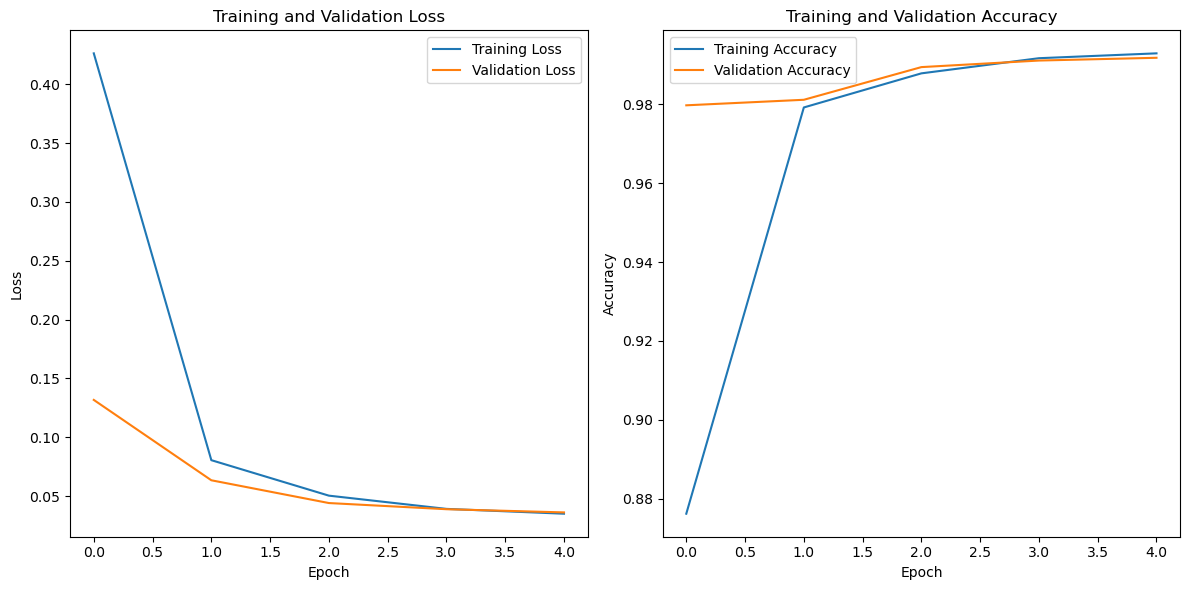

In [97]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()